<a href="https://colab.research.google.com/github/JorgeZarama/TFM/blob/main/LSTM_Test_de_Stock_Market_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar Librería

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Attention, Layer, Input, Dropout, concatenate
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
from tensorflow.keras.optimizers import Adam

Extracción de Datos


In [ ]:
# 1. Extracción de datos
symbol = 'GOOGL'
df = yf.download(symbol, start='2004-08-20', end='2024-07-31', interval='1d')
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
print(df.head())

[*********************100%***********************]  1 of 1 completed

        Date      Open      High       Low     Close  Adj Close     Volume
0 2004-08-20  2.527778  2.729730  2.515015  2.710460   2.703765  456686856
1 2004-08-23  2.771522  2.839840  2.728979  2.737738   2.730975  365122512
2 2004-08-24  2.783784  2.792793  2.591842  2.624374   2.617892  304946748
3 2004-08-25  2.626627  2.702703  2.599600  2.652653   2.646101  183772044
4 2004-08-26  2.626376  2.701451  2.619119  2.700450   2.693780  141897960


Revisar la Data

In [ ]:
display(df.describe(include='all'))
df.info()

,Date,Open,High,Low,Close,Adj Close,Volume
count,5019,5019.000000,5019.000000,5019.000000,5019.000000,5019.000000,5.019000e+03
mean,2014-08-08 10:01:04.554692096,45.309724,45.784195,44.843776,45.325722,45.215203,1.173464e+08
min,2004-08-20 00:00:00,2.482232,2.546046,2.475976,2.502753,2.496571,9.312000e+06
25%,2009-08-13 12:00:00,13.097973,13.210085,12.943944,13.098223,13.065869,3.104200e+07
50%,2014-08-08 00:00:00,27.608999,27.850000,27.345501,27.584499,27.516365,5.975219e+07
75%,2019-08-03 12:00:00,60.459000,61.028749,60.110748,60.546499,60.396944,1.418720e+08
max,2024-07-30 00:00:00,190.309998,191.750000,189.029999,191.179993,190.926636,1.643023e+09
std,NaN,42.958750,43.431968,42.522119,42.989926,42.888262,1.475160e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5019 entries, 0 to 5018
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5019 non-null   datetime64[ns]
 1   Open       5019 non-null   float64       
 2   High       5019 non-null   float64       
 3   Low        5019 non-null   float64       
 4   Close      5019 non-null   float64       
 5   Adj Close  5019 non-null   float64       
 6   Volume     5019 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 274.6 KB


Gráficamos el valor de la acción (precio de cierre)

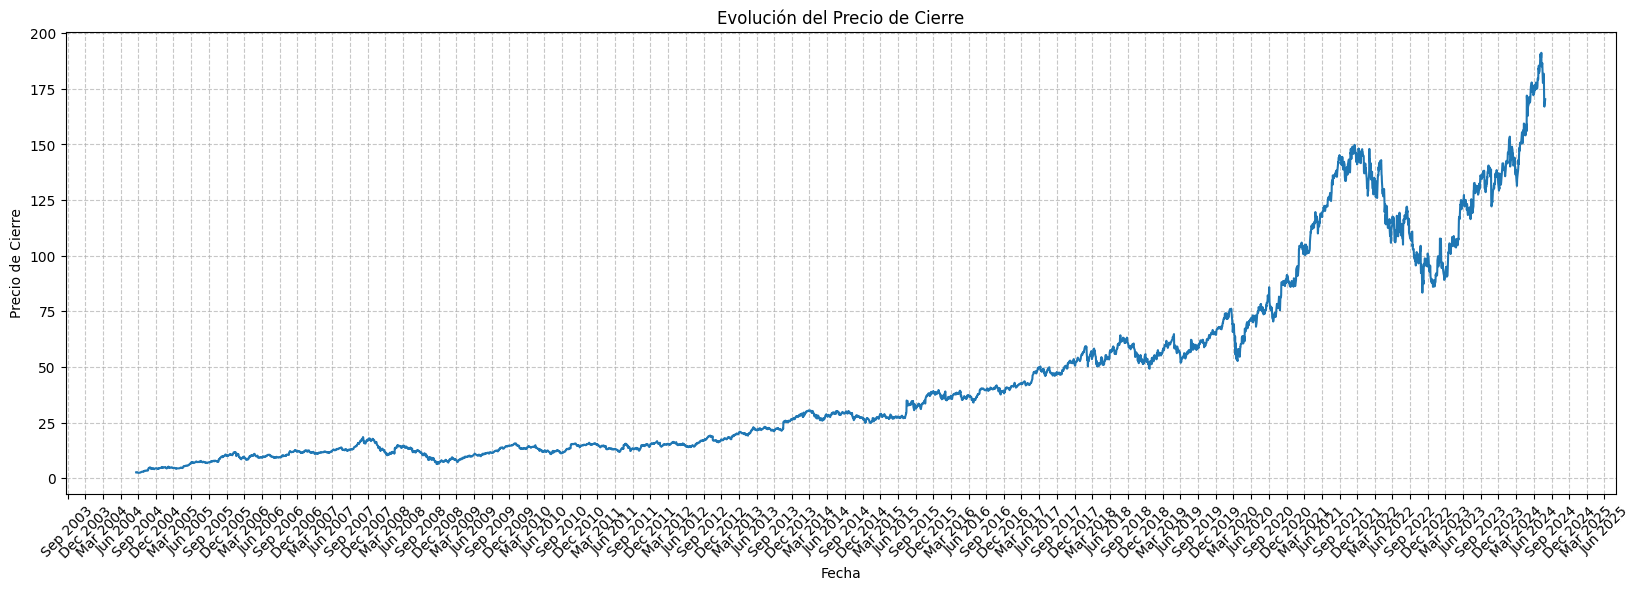

In [ ]:
# Filtrar los datos por el rango de fechas

df_filtrado = df[(df['Date'] >= '2004-08-20') & (df['Date'] <= '2024-07-31')]

# Crear el gráfico de línea
plt.figure(figsize=(20, 6))
sns.lineplot(x='Date', y='Close', data=df_filtrado)

# Personalizar el eje x para mostrar meses y años
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Agregar título y etiquetas a los ejes
plt.title('Evolución del Precio de Cierre')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')

# Agregar una cuadrícula para facilitar la lectura
plt.grid(True, linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

Agregamos una Columna llamada Porcentaje_Cambio_Superior que relaciona el precio de cierre del registro del día con el cierre del día siguiente


In [ ]:

# 2 Crear la columna de tendencia respecto al día anterior
# df['Tendencia_Cambio_Superior'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
# Calcular el porcentaje de cambio respecto al día anterior
df['Porcentaje_Cambio_Superior'] = ((df['Close'].shift(-1) - df['Close']) / df['Close']) * 100
#Sacamos los valores con NaN
df = df.iloc[:-1]
display(df.head(5))
display(df.tail(5))


,Date,Open,High,Low,Close,Adj Close,Volume,Porcentaje_Cambio_Superior
0,2004-08-20,2.527778,2.729730,2.515015,2.710460,2.703765,456686856,1.006395
1,2004-08-23,2.771522,2.839840,2.728979,2.737738,2.730975,365122512,-4.140790
2,2004-08-24,2.783784,2.792793,2.591842,2.624374,2.617892,304946748,1.077555
3,2004-08-25,2.626627,2.702703,2.599600,2.652653,2.646101,183772044,1.801855
4,2004-08-26,2.626376,2.701451,2.619119,2.700450,2.693780,141897960,-1.630988


,Date,Open,High,Low,Close,Adj Close,Volume,Porcentaje_Cambio_Superior
5013,2024-07-23,182.050003,183.610001,181.539993,181.789993,181.549088,36352700,-5.038775
5014,2024-07-24,173.600006,176.190002,171.820007,172.630005,172.401230,49585200,-3.099117
5015,2024-07-25,172.520004,173.419998,167.190002,167.279999,167.058319,44852000,-0.167383
5016,2024-07-26,167.149994,168.089996,164.059998,167.000000,166.778687,41336900,1.514969
5017,2024-07-29,168.830002,170.429993,167.990005,169.529999,169.305344,20293800,0.448295


Seleccionar las características y la variable objetivo

In [ ]:
# 3. Dividir los datos y estandarizar las características
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
target = 'Porcentaje_Cambio_Superior'

train_size = int(len(df) * 0.9)
train_data, test_data = df[:train_size], df[train_size:]

# Separar características y target
X_train = train_data[features]
X_test = test_data[features]
y_train = train_data[target].values.reshape(-1, 1)
y_test = test_data[target].values.reshape(-1, 1)

# Escalar las características
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Escalar la variable objetivo usando MinMaxScaler
#target_scaler = MinMaxScaler()
target_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)

# Función para crear secuencias
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)



## Arquitectura del Modelo y Entrenamiento LSTM

In [ ]:
# Crear secuencias (ajustar la ventana de tiempo si es necesario)
time_steps = 20
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, time_steps)

#Arquitecture del Modelo

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Agregar dropout para evitar overfitting
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))  # Capa de salida

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0149 - val_loss: 0.0043
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0044 - val_loss: 0.0066
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 9/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 10/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 11/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 12/100
225/225 ━━━━━━━━━━━━━━━

Evaluación del modelo

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8163
perdidas de test 4.018272399902344
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test Loss (MSE): 4.018272399902344
Mean Absolute Error (MAE): 45.283145690472175
Mean Squared Error (MSE): 4019.013225285058
Root Mean Squared Error (RMSE): 63.39568774991764
R-squared (R²): -0.01727690620357114


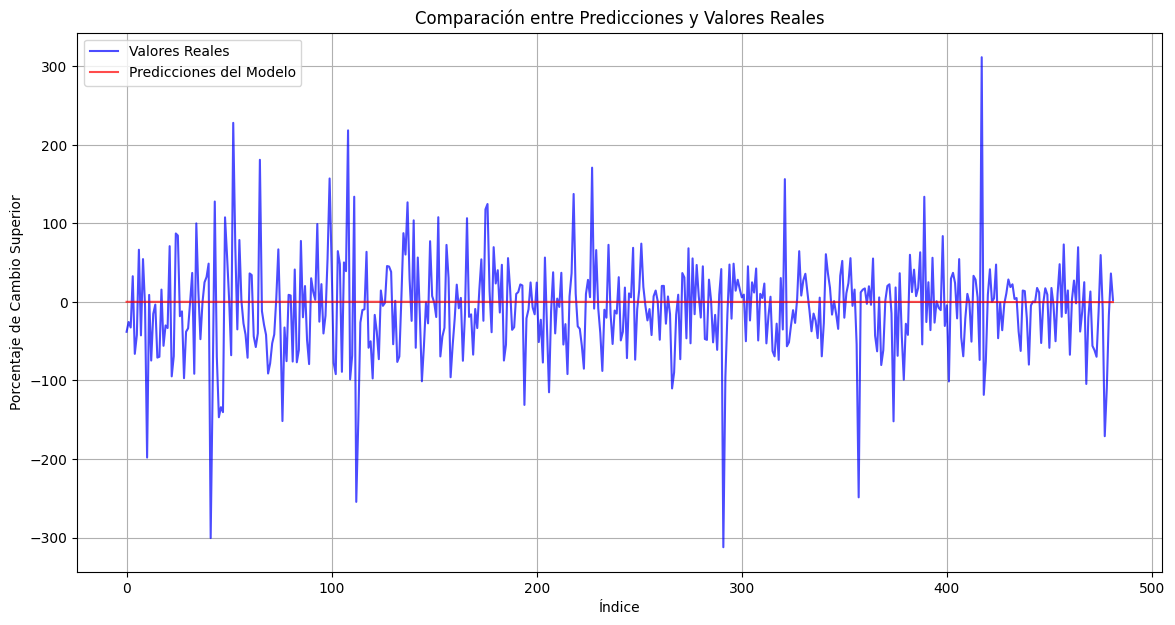

In [ ]:

# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test)
print("perdidas de test", test_loss)
# Predicción
predictions = model.predict(X_test)

# Desescalar las predicciones
predictions = target_scaler.inverse_transform(predictions)
y_test = target_scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

## Arquitectura 2 LSTM Reducir complejidad

In [ ]:
# Crear secuencias (ajustar la ventana de tiempo si es necesario)
time_steps = 20
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# 4. Arquitectura y entrenamiento del modelo
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1, activation='linear'))  # Mantener salida lineal

# Compilar el modelo con mean_absolute_error como métrica de pérdida
model.compile(optimizer='adam', loss='mean_absolute_error')

# Ajuste de EarlyStopping para mayor paciencia
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_test, y_test), callbacks=[early_stop])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.1051 - val_loss: 0.0454
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0481 - val_loss: 0.0482
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0436 - val_loss: 0.0458
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0422 - val_loss: 0.0451
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0420 - val_loss: 0.0450
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0407 - val_loss: 0.0450
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 0.0412 - val_loss: 0.0462
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0418 - val_loss: 0.0460
Epoch 9/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 0.0405 - val_loss: 0.0458
Epoch 10/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0410 - val_loss: 0.0450
Epoch 11/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0411 - val_loss: 0.0455
Epoch 12/100
225/225 ━━━━━

Evaluación del modelo

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6265
perdidas de test 1.4319819211959839
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test Loss (MSE): 1.4319819211959839
Mean Absolute Error (MAE): 45.28742176864722
Mean Squared Error (MSE): 4020.966778113233
Root Mean Squared Error (RMSE): 63.41109349406642
R-squared (R²): -0.01777138185362559


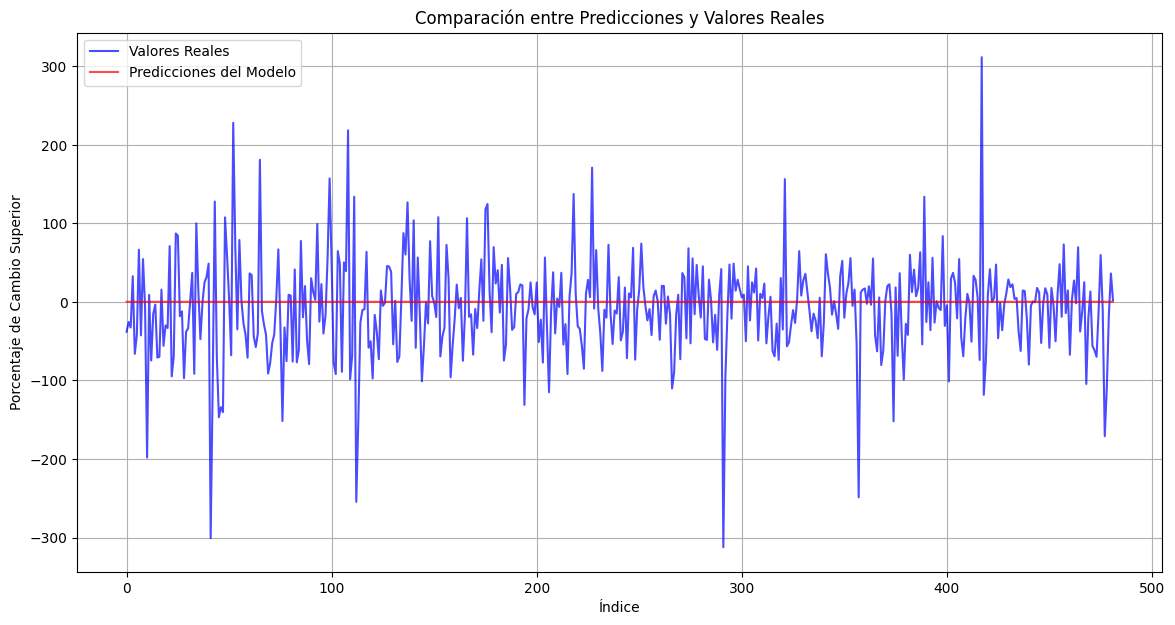

In [ ]:

# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test)
print("perdidas de test", test_loss)
# Predicción
predictions = model.predict(X_test)

# Desescalar las predicciones
predictions = target_scaler.inverse_transform(predictions)
y_test = target_scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

## Modelo LSTM bidireccional con dropout y atención (opcional)

In [ ]:
# Crear secuencias (ajustar la ventana de tiempo si es necesario)
time_steps = 20
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, time_steps)

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
# ... (Agregar capas de atención si es necesario)
model.add(LSTM(units=100, return_sequences=False, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Entrenar el modelo

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_test, y_test), callbacks=[early_stop])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.0178 - val_loss: 0.0044
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.0036 - val_loss: 0.0046
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 9/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 10/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 11/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 12/100
225/2

Evaluar Modelo




16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0047
perdidas de test 0.003949053585529327
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
Test Loss (MSE): 0.003949053585529327
Mean Absolute Error (MAE): 1.4255826454705016
Mean Squared Error (MSE): 3.9497821293117297
Root Mean Squared Error (RMSE): 1.987405879359254
R-squared (R²): 6.221611158496732e-05


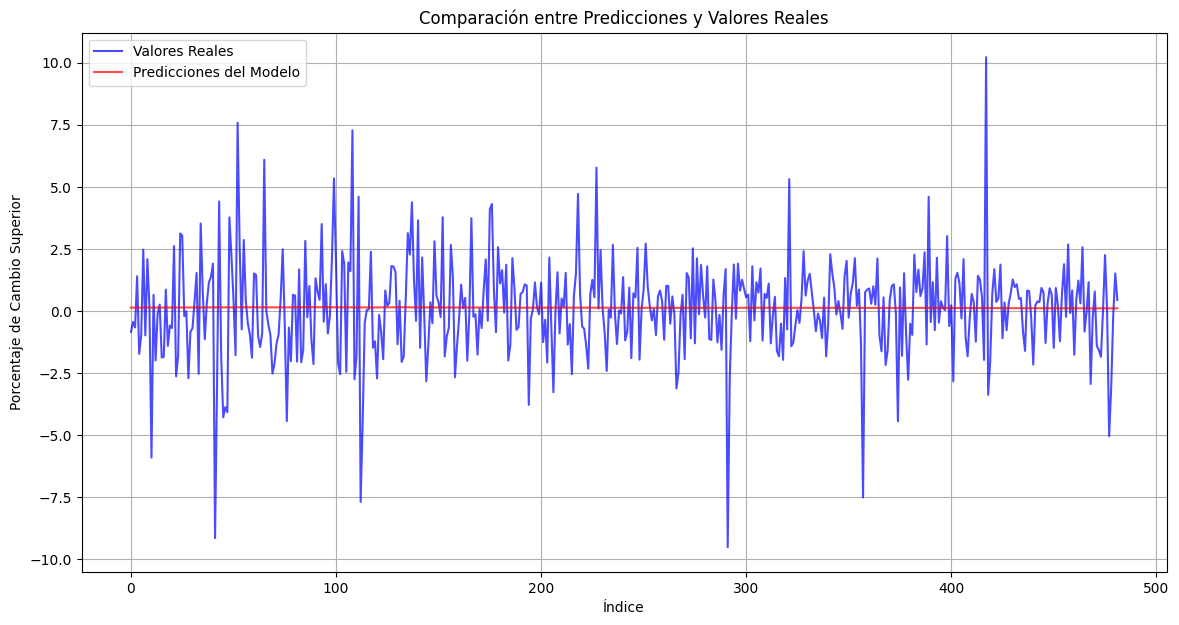

In [ ]:

# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test)
print("perdidas de test", test_loss)
# Predicción
predictions = model.predict(X_test)

# Desescalar las predicciones
predictions = target_scaler.inverse_transform(predictions)
y_test = target_scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

## Arquitectura con Atención

In [ ]:
time_steps = 60
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Define the query and value inputs for the attention layer
query = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Adjust shape if necessary
value = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Adjust shape if necessary

# Create the LSTM layers
lstm_layer1 = LSTM(units=100, return_sequences=True)(query)
lstm_layer1 = Dropout(0.2)(lstm_layer1)

# Apply the attention layer
attention_layer = Attention()([query, value])

# Concatenate the attention output with the LSTM output
merged_layer = concatenate([lstm_layer1, attention_layer], axis=-1)

lstm_layer2 = LSTM(units=100, return_sequences=False)(merged_layer)
lstm_layer2 = Dropout(0.2)(lstm_layer2)
dense_layer1 = Dense(units=50, activation='relu')(lstm_layer2)
output_layer = Dense(units=1)(dense_layer1)

# Create the model
model = Model(inputs=[query, value], outputs=output_layer)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model (adjust X_train and y_train if necessary)
history = model.fit([X_train, X_train], y_train, epochs=100, batch_size=32, validation_data=([X_test, X_test], y_test))

Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - loss: 0.0217 - val_loss: 0.0070
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 0.0044 - val_loss: 0.0086
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - loss: 0.0037 - val_loss: 0.0062
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 9/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 10/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 11/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 12

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0054
perdidas de test 0.004011544398963451
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
Test Loss (MSE): 0.004011544398963451
Mean Absolute Error (MAE): 1.4306408563516269
Mean Squared Error (MSE): 4.012283952677677
Root Mean Squared Error (RMSE): 2.0030686340407002
R-squared (R²): -0.006410112026101533


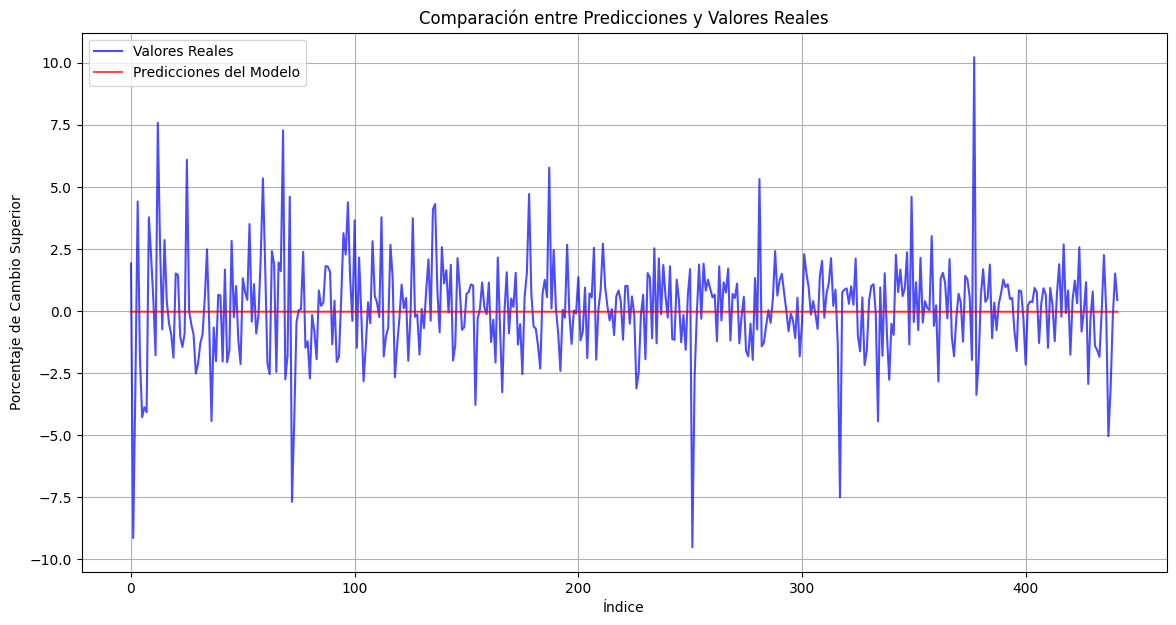

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate([X_test, X_test], y_test) # Pass X_test twice as input
print("perdidas de test", test_loss)
# Predicción
predictions = model.predict([X_test, X_test]) # Pass X_test twice as input

# Desescalar las predicciones
predictions = target_scaler.inverse_transform(predictions)
y_test = target_scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

## Red Convolucional

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np

time_steps = 60
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Reshape para formato de CNN
# Remove np.squeeze as it's not needed
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2], 1))

# Modelo CNN
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=60, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.2391 - val_loss: 0.0125
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0052 - val_loss: 0.0117
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0054 - val_loss: 0.0112
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0067 - val_loss: 0.0047
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0046 - val_loss: 0.0198
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0042 - val_loss: 0.0057
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0042 - val_loss: 0.0146
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4845
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test Loss (MSE): 4.059753894805908
Mean Absolute Error (MAE): 45.06011713486152
Mean Squared Error (MSE): 4060.5023656505564
Root Mean Squared Error (RMSE): 63.72207125989045
R-squared (R²): -0.018317038322947177


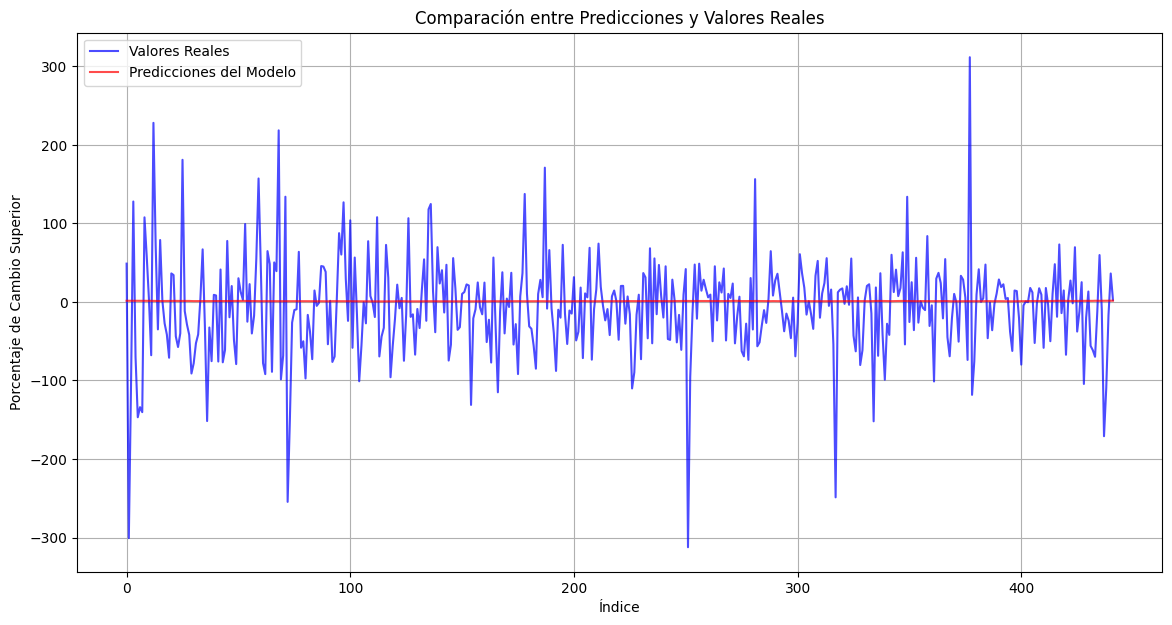

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

# Desescalar las predicciones
predictions = target_scaler.inverse_transform(predictions)
y_test = target_scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

## CNN - LSTM


In [ ]:
time_steps = 60
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Reshape para formato de CNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2])) # Remove extra dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2])) # Remove extra dimension

# Modelo CNN-LSTM
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]))) # Update input shape
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0175 - val_loss: 0.0210
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0150 - val_loss: 0.0161
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0148 - val_loss: 0.0179
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0129 - val_loss: 0.0195
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0152 - val_loss: 0.0160
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0154 - val_loss: 0.0168
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0148 - val_loss: 0.0159
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.0141 - val_loss: 0.0173
Epoch 9/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0143 - val_loss: 0.0162
Epoch 10/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0141 - val_loss: 0.0165
Epoch 11/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0139 - val_loss: 0.0164
Epoch 12/100
140/140 ━━━━━━━━━━━━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0233
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Test Loss (MSE): 0.016749536618590355
Mean Absolute Error (MAE): 1.4552291897301834
Mean Squared Error (MSE): 4.18815643420899
Root Mean Squared Error (RMSE): 2.046498579087948
R-squared (R²): -0.05052459792187469


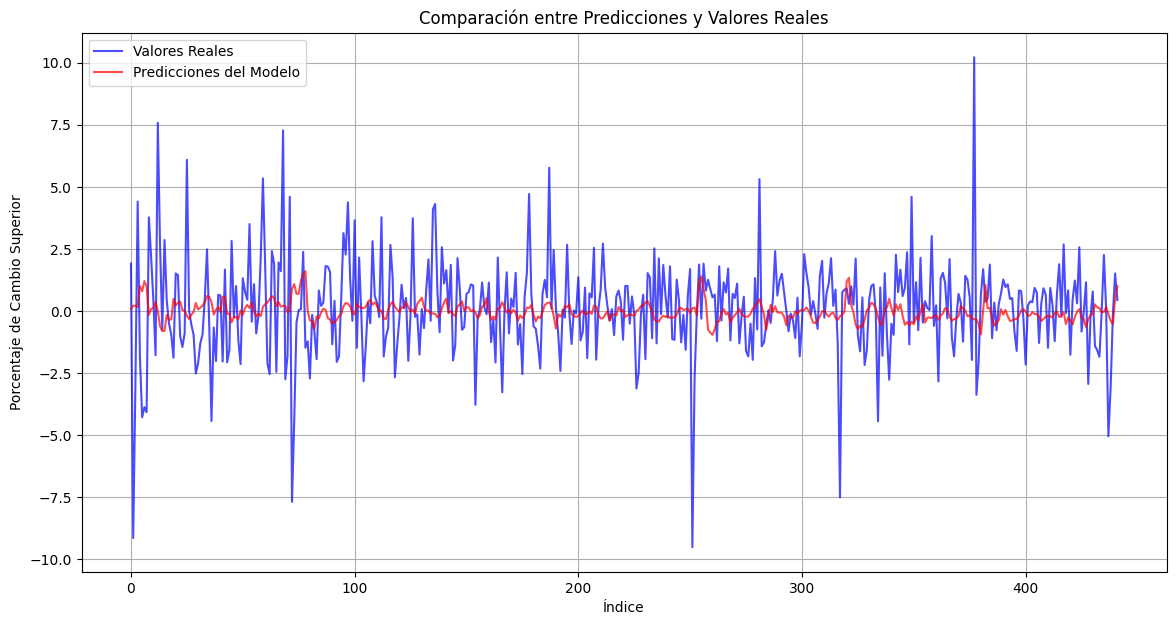

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

# Desescalar las predicciones
predictions = target_scaler.inverse_transform(predictions)
y_test = target_scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np

#tamaño del filtro y la cantidad de filtros en Conv1D
time_steps = 60
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Reshape para formato de CNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2])) # Remove extra dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2])) # Remove extra dimension

# Modelo CNN-LSTM
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.0234 - val_loss: 0.0172
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 0.0147 - val_loss: 0.0161
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0169 - val_loss: 0.0161
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0148 - val_loss: 0.0163
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0144 - val_loss: 0.0160
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0156 - val_loss: 0.0160
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0137 - val_loss: 0.0167
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0133 - val_loss: 0.0161
Epoch 9/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0138 - val_loss: 0.0163
Epoch 10/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0159 - val_loss: 0.0162
Epoch 11/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0150 - val_loss: 0.0160
Epoch 12/100
140/140 ━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0224
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Test Loss (MSE): 0.01617145538330078
Mean Absolute Error (MAE): 1.4112042079465428
Mean Squared Error (MSE): 4.04360950751306
Root Mean Squared Error (RMSE): 2.010872822312008
R-squared (R²): -0.014267570651410821


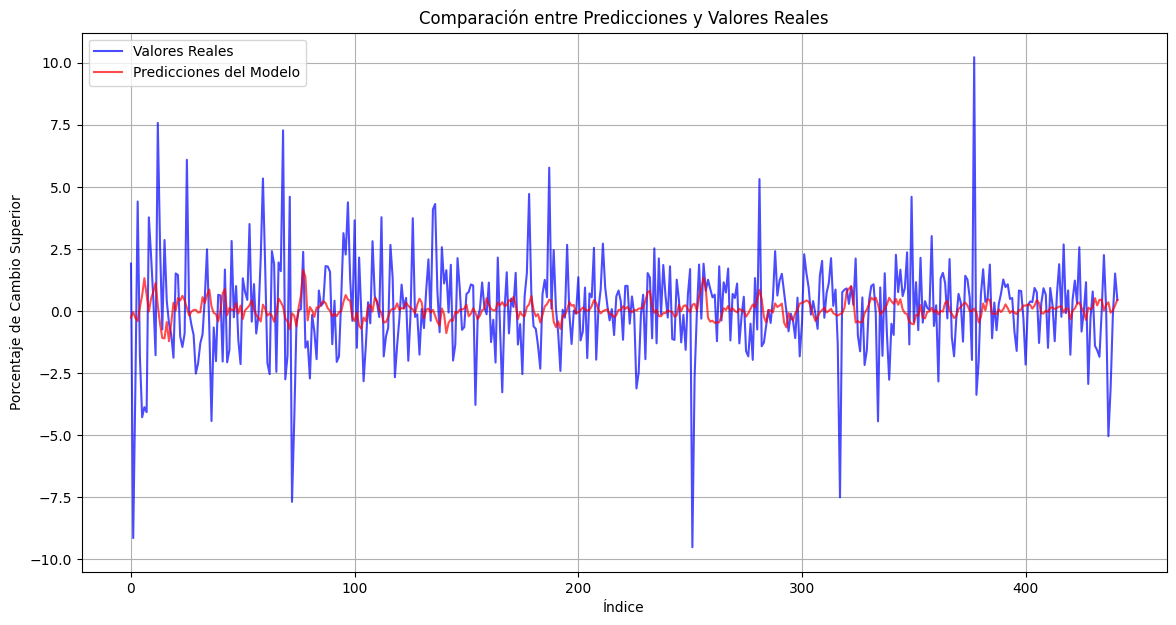

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

# Desescalar las predicciones
predictions = target_scaler.inverse_transform(predictions)
y_test = target_scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np

#tamaño del filtro y la cantidad de filtros en Conv1D
time_steps = 60
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Reshape para formato de CNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2])) # Remove extra dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2])) # Remove extra dimension

# Modelo CNN-LSTM
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0204 - val_loss: 0.0176
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0135 - val_loss: 0.0159
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0148 - val_loss: 0.0162
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.0153 - val_loss: 0.0160
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0151 - val_loss: 0.0170
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0146 - val_loss: 0.0159
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0136 - val_loss: 0.0159
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0138 - val_loss: 0.0160
Epoch 9/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0147 - val_loss: 0.0167
Epoch 10/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0145 - val_loss: 0.0159
Epoch 11/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0135 - val_loss: 0.0160
Epoch 12/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0217
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Test Loss (MSE): 0.016185251995921135
Mean Absolute Error (MAE): 1.4409346245073857
Mean Squared Error (MSE): 4.047058977235212
Root Mean Squared Error (RMSE): 2.0117303440658274
R-squared (R²): -0.015132808817613919


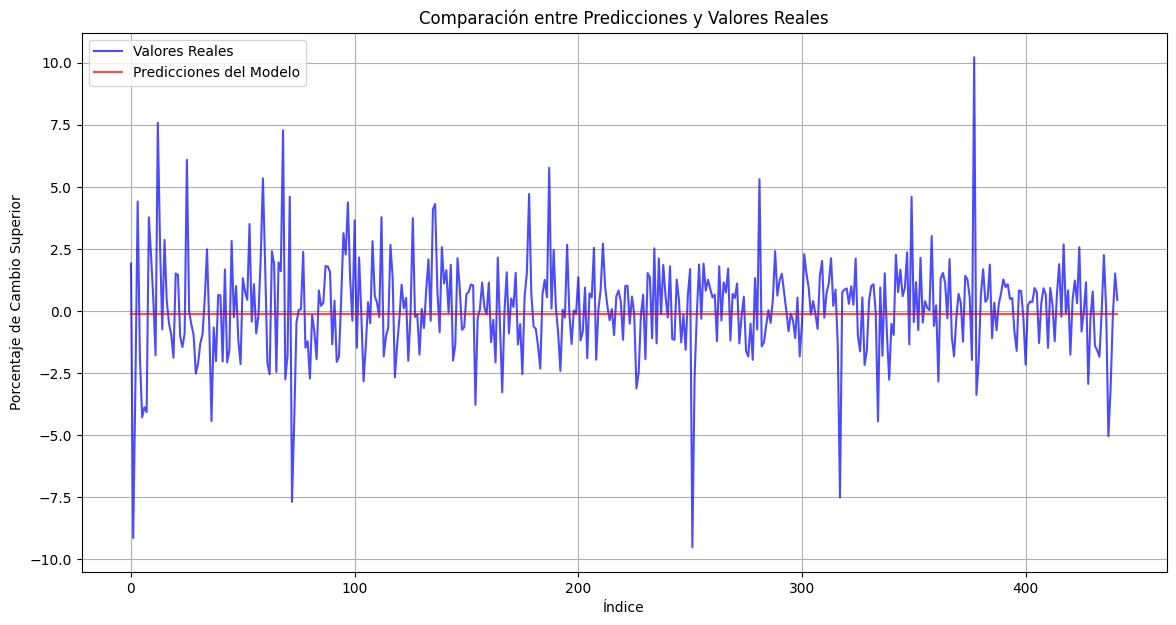

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

# Desescalar las predicciones
predictions = target_scaler.inverse_transform(predictions)
y_test = target_scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np

#tamaño del filtro y la cantidad de filtros en Conv1D
time_steps = 120
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Reshape para formato de CNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2])) # Remove extra dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2])) # Remove extra dimension

# Modelo CNN-LSTM
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0282 - val_loss: 0.0139
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - loss: 0.0150 - val_loss: 0.0139
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.0156 - val_loss: 0.0142
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.0148 - val_loss: 0.0165
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 0.0148 - val_loss: 0.0150
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 8/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - loss: 0.0136 - val_loss: 0.0152
Epoch 9/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0141 - val_loss: 0.0146
Epoch 10/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - loss: 0.0148 - val_loss: 0.0145
Epoch 11/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 0.0134 - val_loss: 0.0141
Epoch 12/100
138/138 ━━━━━━━━━━━

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0176
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Test Loss (MSE): 0.01438357774168253
Mean Absolute Error (MAE): 1.348493702495516
Mean Squared Error (MSE): 3.5965579992690064
Root Mean Squared Error (RMSE): 1.896459332353058
R-squared (R²): -0.03986019847164535


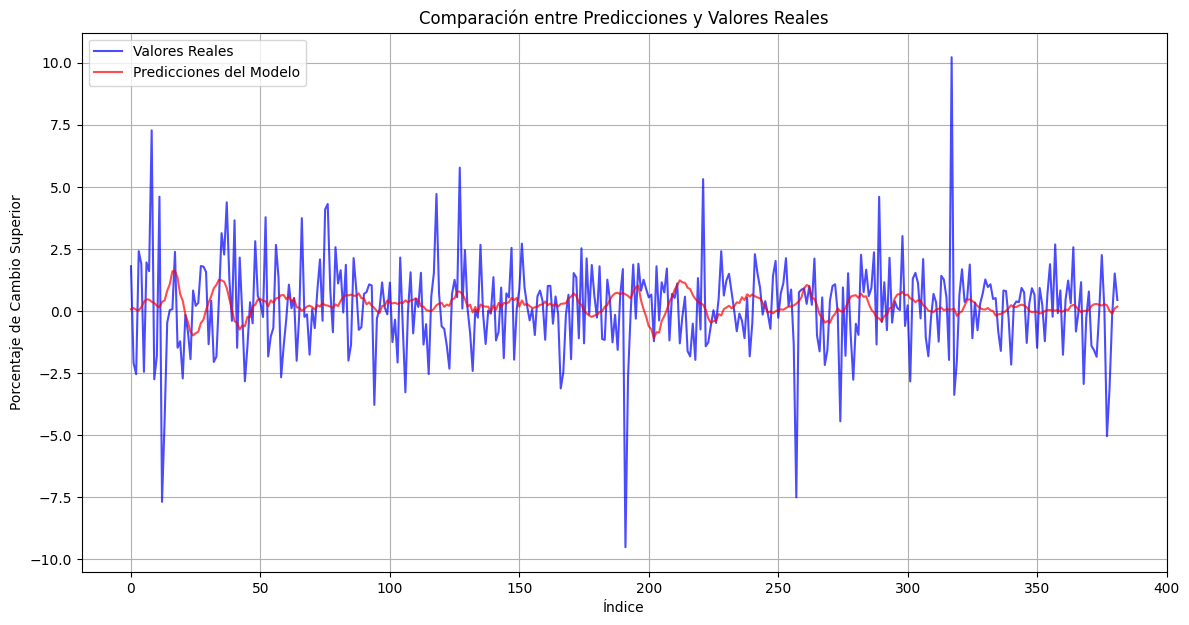

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

# Desescalar las predicciones
predictions = target_scaler.inverse_transform(predictions)
y_test = target_scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np

#tamaño del filtro y la cantidad de filtros en Conv1D
time_steps = 120
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Reshape para formato de CNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2])) # Remove extra dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2])) # Remove extra dimension

# Modelo CNN-LSTM
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - loss: 0.0252 - val_loss: 0.0148
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0162 - val_loss: 0.0148
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - loss: 0.0149 - val_loss: 0.0142
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0149 - val_loss: 0.0143
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 0.0140 - val_loss: 0.0139
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - loss: 0.0155 - val_loss: 0.0142
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 0.0144 - val_loss: 0.0139
Epoch 8/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - loss: 0.0145 - val_loss: 0.0138
Epoch 9/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 0.0134 - val_loss: 0.0138
Epoch 10/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 0.0143 - val_loss: 0.0139
Epoch 11/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - loss: 0.0137 - val_loss: 0.0138
Epoch 12/100
138/138 ━━━━━━━━━━━

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.3889
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test Loss (MSE): 3.6360414028167725
Mean Absolute Error (MAE): 21.912596555366527
Mean Squared Error (MSE): 909.1779465637428
Root Mean Squared Error (RMSE): 30.152577776431368
R-squared (R²): -0.05127583802336311


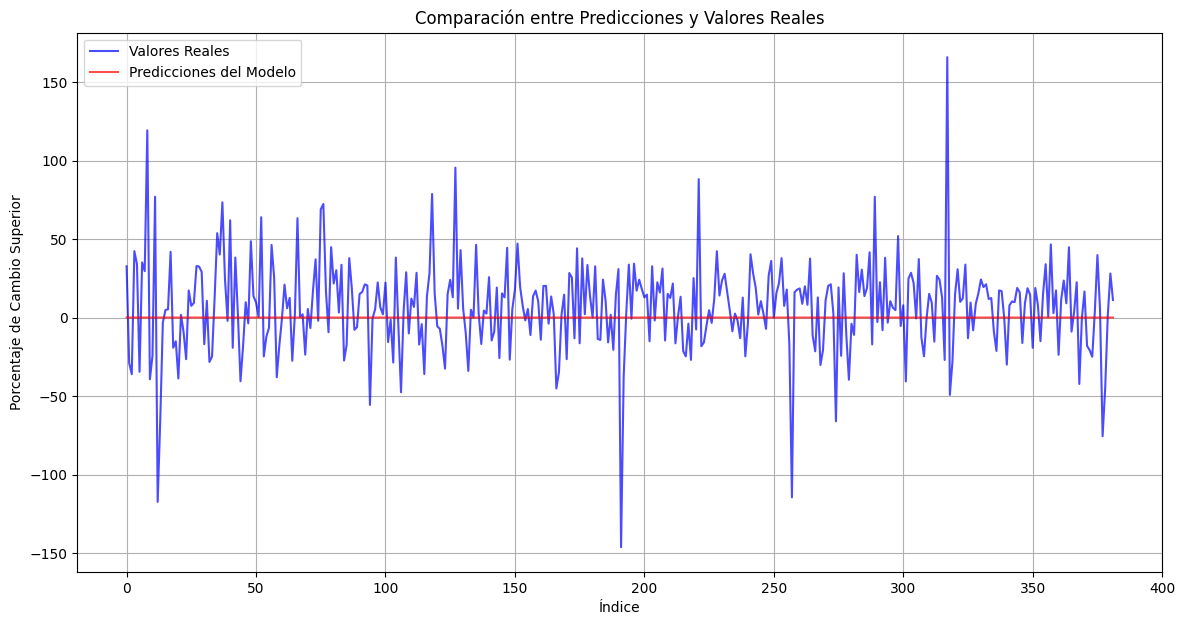

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

# Desescalar las predicciones
predictions = target_scaler.inverse_transform(predictions)
y_test = target_scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np
from tensorflow.keras.layers import BatchNormalization

#tamaño del filtro y la cantidad de filtros en Conv1D
time_steps = 120
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Reshape para formato de CNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2])) # Remove extra dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2])) # Remove extra dimension

# Modelo CNN-LSTM
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=50, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(units=50))
model.add(BatchNormalization())
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - loss: 0.1695 - val_loss: 0.0270
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - loss: 0.0243 - val_loss: 0.0159
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 0.0237 - val_loss: 0.0685
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.0211 - val_loss: 0.0186
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - loss: 0.0186 - val_loss: 0.0223
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - loss: 0.0179 - val_loss: 0.0171
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - loss: 0.0192 - val_loss: 0.0160
Epoch 8/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 0.0179 - val_loss: 0.0210
Epoch 9/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 0.0162 - val_loss: 0.0139
Epoch 10/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 0.0170 - val_loss: 0.0144
Epoch 11/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - loss: 0.0180 - val_loss: 0.0163
Epoch 12/100
138/13

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0174
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Test Loss (MSE): 0.01445724442601204
Mean Absolute Error (MAE): 1.380474737821745
Mean Squared Error (MSE): 3.6149779508435365
Root Mean Squared Error (RMSE): 1.901309535778837
R-squared (R²): -0.04518589445764709


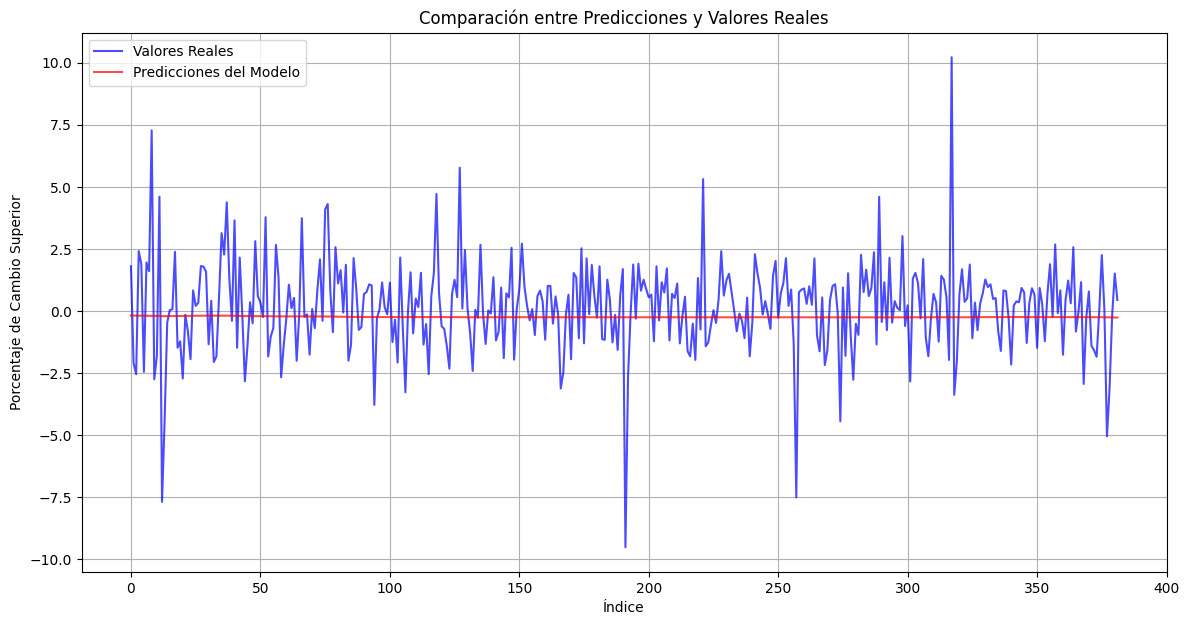

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

# Desescalar las predicciones
predictions = target_scaler.inverse_transform(predictions)
y_test = target_scaler.inverse_transform(y_test)

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Mostrar las métricas
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valores Reales', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicciones del Modelo', color='red', alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Porcentaje de Cambio Superior')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()